<a href="https://colab.research.google.com/github/bustyAI/stroke-predictions/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn import set_config
set_config(display="diagram")

In [3]:
file_name = "/content/drive/MyDrive/Coding Dojo/Project 2/Data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_name)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# making a function that prints out our data
def print_scores(model):
  model_name = str(model).split(",")[-1]
  model_name = model_name.split("(")

  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  train_acc_score = accuracy_score(y_train, train_preds)
  test_acc_score = accuracy_score(y_test, test_preds)

  train_recall_score = recall_score(y_train, train_preds)
  test_recall_score = recall_score(y_test, test_preds)

  train_prec_score = precision_score(y_train, train_preds)
  test_prec_score = precision_score(y_test, test_preds)

  print("Accuracy Scores:\n")
  print(f"{model_name[0]} Training Score: {train_acc_score}")
  print(f"{model_name[0]} Testing Score: {test_acc_score}")
  print("------------------------------------------------------------------")

  print("\nRecall Scores:\n")
  print(f"{model_name[0]} Training Score: {train_recall_score}")
  print(f"{model_name[0]} Testing Score: {test_recall_score}")
  print("------------------------------------------------------------------")

  print("\nPrecision Scores:\n")
  print(f"{model_name[0]} Training Score: {train_prec_score}")
  print(f"{model_name[0]} Testing Score: {test_prec_score}")

In [5]:
# making a function to print our smote scores
def smote_scores(model):
  model.fit(X_train_smote, y_train_smote)

  smote_predictions_train = model.predict(X_train_smote)
  smote_predictions_test = model.predict(X_test_smote)


  print(f"Smote Training Accuracy Score: {accuracy_score(y_train_smote, smote_predictions_train)}")
  print(f"Smote Testing Accuracy Score: {accuracy_score(y_test_smote, smote_predictions_test)}")
  print("------------------------------------------------------------------")

  print(f"Smote Training Recall Score: {recall_score(y_train_smote, smote_predictions_train)}")
  print(f"Smote Testing Recall Score: {recall_score(y_test_smote, smote_predictions_test)}")
  print("------------------------------------------------------------------")

  print(f"Smote Training Precision Score: {recall_score(y_train_smote, smote_predictions_train)}")
  print(f"Smote Testing Precision Score: {precision_score(y_test_smote, smote_predictions_test)}")

# 1. EDA


In [6]:
# getting info on our data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Dealing with duplicates and deleting uncessary columns

In [7]:
# checking if we have duplicate rows
df.duplicated().sum()

0

In [8]:
# I am going to drop the "id" column as it is just a unique identifier
df = df.drop(columns="id")

# checking if column got dropped
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
# renaming "Residence_type" column just for consistency 
df = df.rename(columns={"Residence_type": "residence_type"})

# checking to see if our column got renamed
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Dealing with null values

In [10]:
# checking how much null values we have in bmi
df["bmi"].isnull().sum()

201

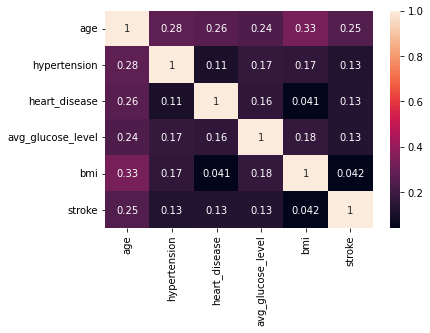

In [11]:
# making a correlation heat map of our data
corr = df.corr()

sns.heatmap(corr, data=df, annot=True)

- Decided to create a heat map to see if their was any correlation between bmi and our other features so I could then explore the data and gain insight to see what I should fill the null values in our bmi with.

- Since there isn't any strong correlation between bmi and our other features, and the way to calculate bmi is by a persons height and weight which our data set does not have. I have decided to drop the 201 columns since there is no way to accurately fill in those values with the data we currently have. We would only be dropping roughly 3.9% of our data, less than 5%.

- Also no strong positive or negative corelations between our features.

In [12]:
# dropping our rows will null values
df = df.dropna()

# checking to see if our rows got dropped
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
# going to drop unknown value for simplicity
df["gender"].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

In [14]:
# finding the row index to drop
df[df.loc[:, "gender"] == "Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [15]:
# dropping the row
df = df.drop(index=3116)

In [16]:
# checking to see if value got dropped
df["gender"].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [17]:
# checking how many rows we ended up with
df.shape

(4908, 11)

 ## Checking for sytax errors and inconsistencies

In [18]:
# saving our dtypes
df_dtypes = df.dtypes
df_dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [19]:
# saving our object dtypes
str_cols = df_dtypes[df_dtypes == "object"].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')

In [20]:
# looping through our values to see if their are any syntax errors or inconsistencies
for col in str_cols:
  print(f"Column: {col}")
  print(df[col].value_counts())
  print("\n\n")

Column: gender
Female    2897
Male      2011
Name: gender, dtype: int64



Column: ever_married
Yes    3204
No     1704
Name: ever_married, dtype: int64



Column: work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64



Column: residence_type
Urban    2490
Rural    2418
Name: residence_type, dtype: int64



Column: smoking_status
never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64





- No syntax errors or inconsistencies

In [21]:
# checking to see if there are any inconsistent or impossible values in our data
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,42.868810,0.091891,0.049511,105.297402,28.89456,0.042584
std,22.556128,0.288901,0.216954,44.425550,7.85432,0.201937
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.10000,0.000000
75%,60.000000,0.000000,0.000000,113.495000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


- Definitely have some outliers, but the outliers are possible. We do have some babies and kids in our data, although not common strokes can happen in younger people so these are also valid. For bmi we also have some very high values but they are not impossible. To conclude, there are outliers but all values are possible.

# 2. Visualizations

## Univariate visuals 

In [22]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Countplot Gender

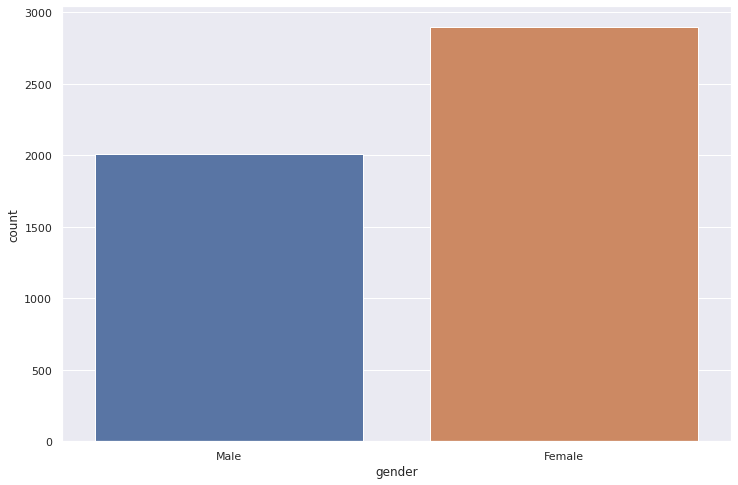

In [23]:
sns.set(style="darkgrid", rc={"figure.figsize":(12,8)})
sns.countplot(data=df, x="gender")

- From the countplot we can see that there are more females than males in this data set. Also 1 data point for other.

### Boxplot Age

Text(0.5, 1.0, 'Distribution of Age')

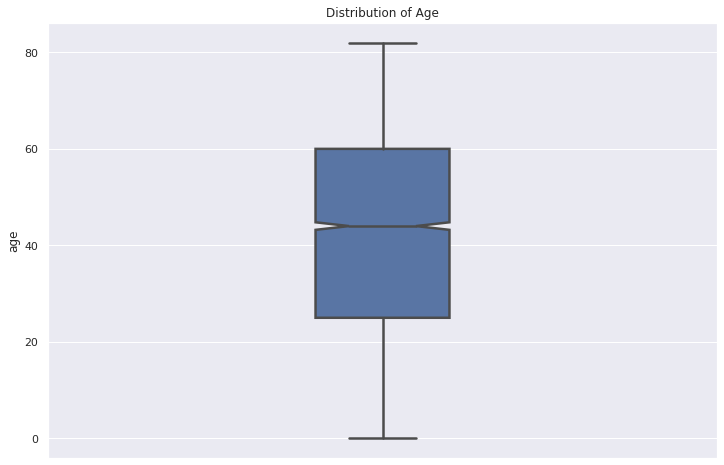

In [24]:
sns.boxplot(data=df, y="age", width=0.2, linewidth=2.5, notch=True)
plt.title("Distribution of Age")

- No outliers for age although our age data does start from as low as 0.08 years. Our mean age is around early 40s and highest age is around early 80s.

### Countplot Hypertension

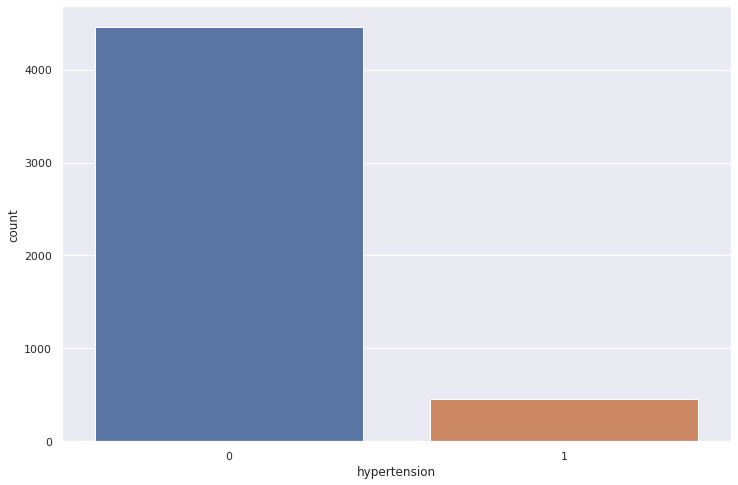

In [25]:
sns.countplot(data=df, x="hypertension")

- From the graph we can clearly see that they're are more people without hypertension than with hypertension.

### Countplot Heart Disease

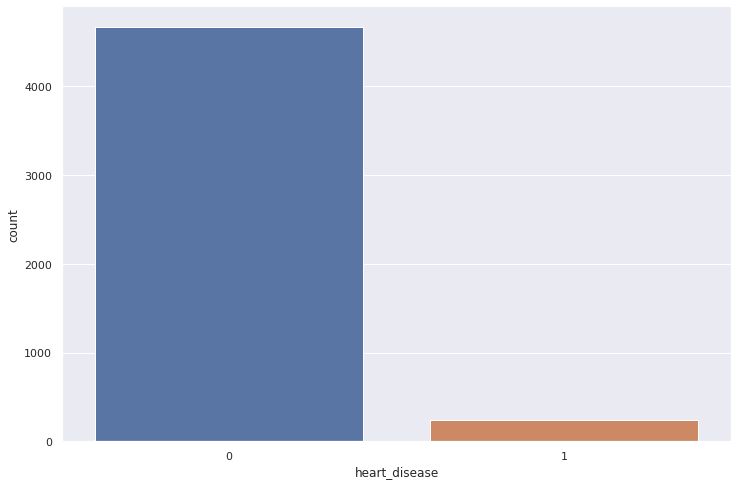

In [26]:
sns.countplot(data=df, x="heart_disease")

- We can see from the graph that the majority do not have heart disease.

### Countplot Ever Married

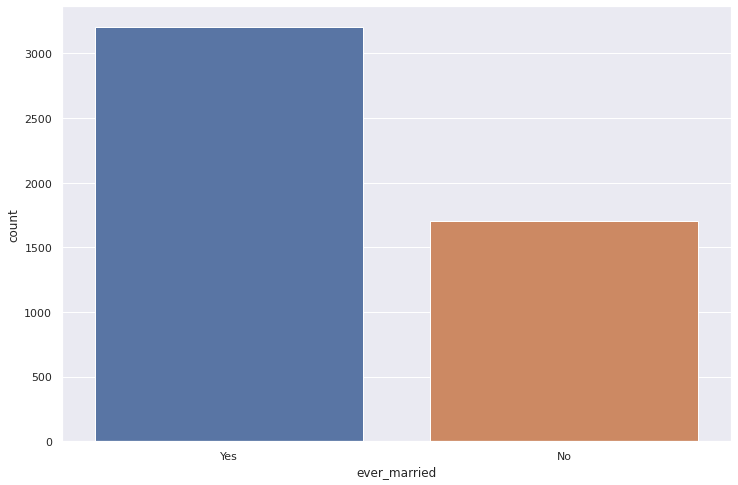

In [27]:
sns.countplot(data=df, x="ever_married")

- Most patients have or have been married. This makes sense even though our data does include those under the age of 18 who aren't legally able to get married, our mean age is early 40s.

### Countplot Work Type

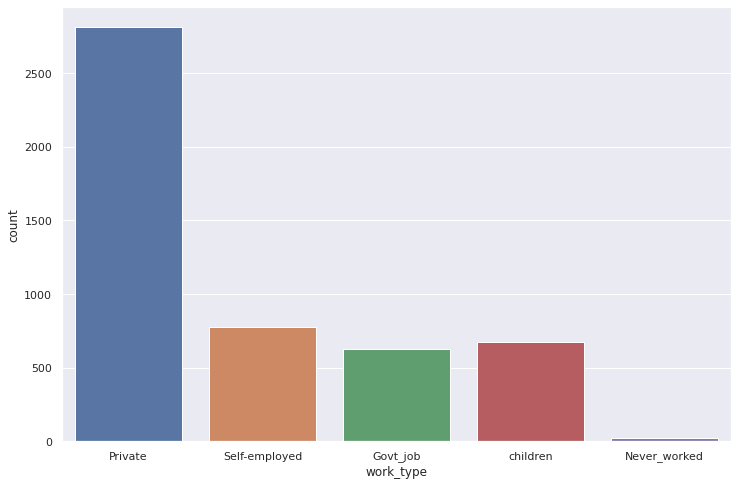

In [28]:
sns.countplot(data=df, x="work_type")

- Majority of patients tended to keep their work type private. We get similar ranges for patients who are self employed, have a government job, or take care of children. We have very few patients who have never worked.

### Countplot Residence Type

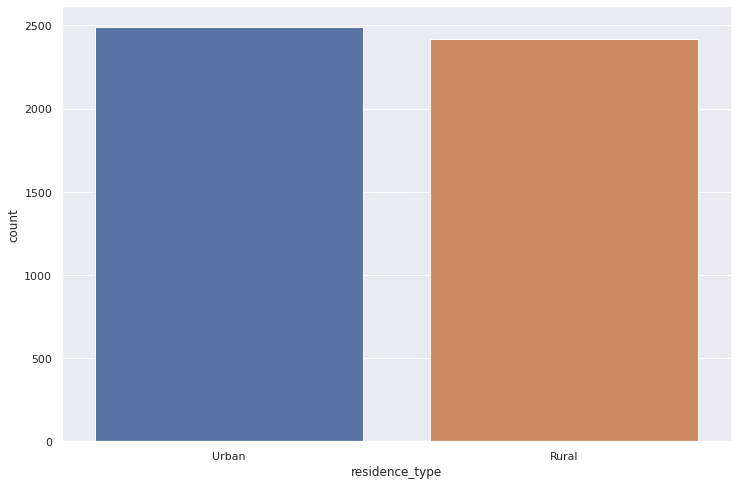

In [29]:
sns.countplot(data=df, x="residence_type")

- Interesting we have a similiar range of entries for patients living in urban areas and rural areas.

### Histogram Average Glucose Level

Text(0.5, 1.0, 'Distribution of Glucose Level')

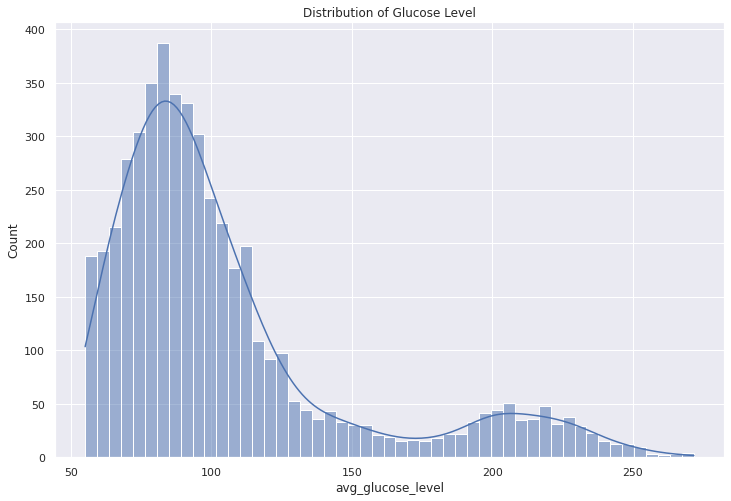

In [30]:
sns.histplot(data=df, x="avg_glucose_level", bins="auto", kde=True)
plt.title("Distribution of Glucose Level")

- We can see that most of our patients fall under the range of of about 60-110. There could be some outliers in the 250s.

### Histogram BMI

Text(0.5, 1.0, 'BMI Distribution')

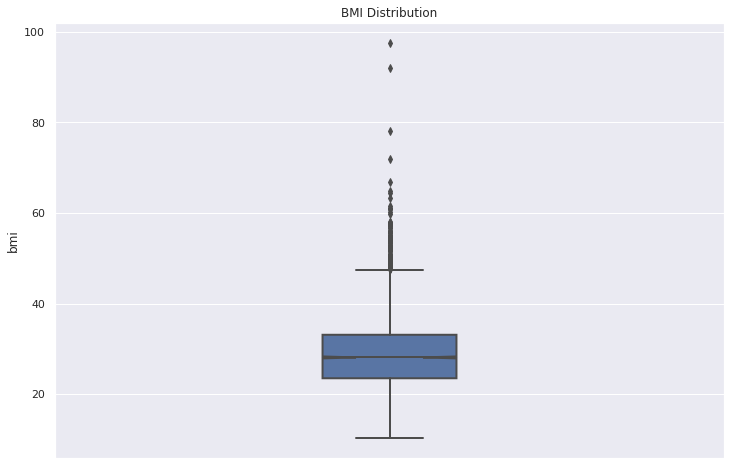

In [31]:
sns.boxplot(data=df, y="bmi", width=0.2, linewidth=2.0, notch=True)
plt.title("BMI Distribution")

- Most of the patients have a bmi within the range of 20-35. There are many outliers. 

### Countplot Smoking Status

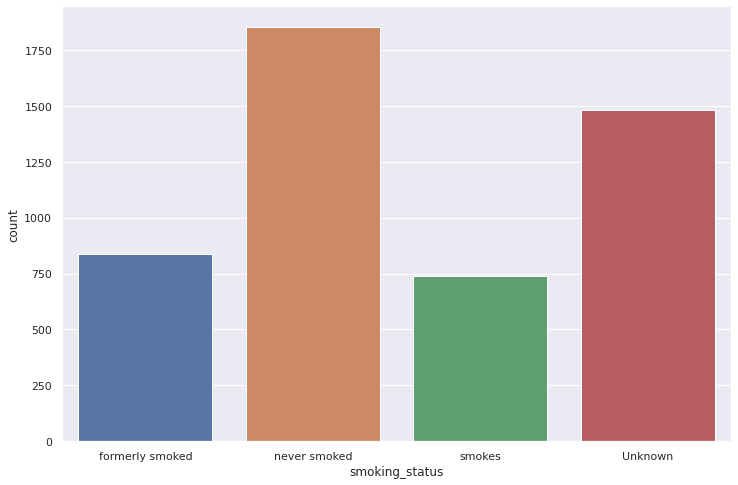

In [32]:
sns.countplot(data=df, x="smoking_status")

- Majority of patients never smoked or it is unknown if they smoke or have ever smoked. Similar values for paitents who smoke or formerly smoked.

### Countplot Stroke

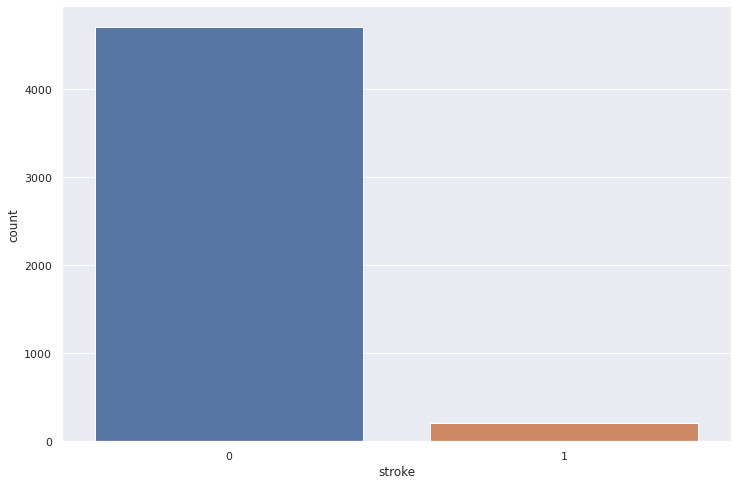

In [33]:
sns.countplot(data=df, x="stroke")

- From the data we can see that it is very imbalanced for our target with very few people having a stroke. 

## Multivariant Visualizations

In [34]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Distribution of BMI by Gender 

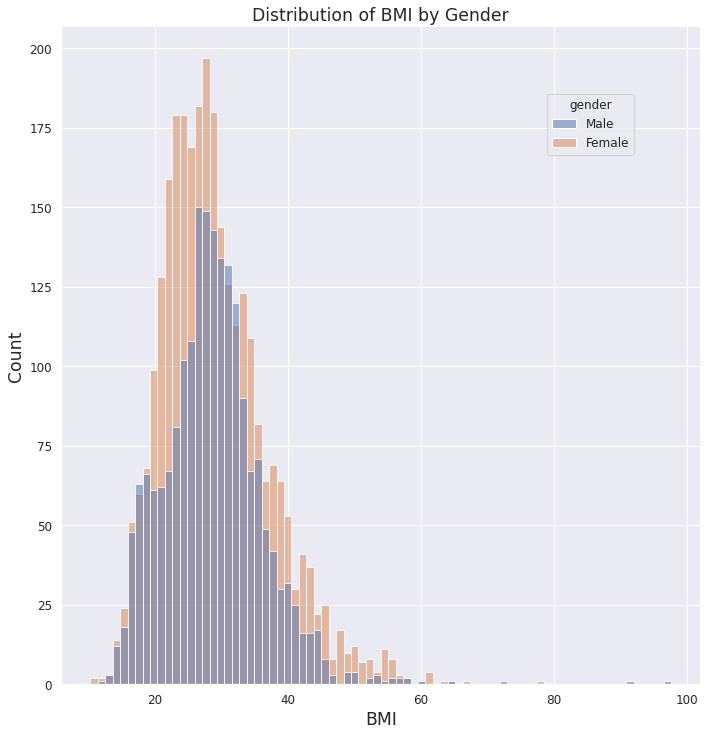

In [35]:
ax = sns.displot(data=df, x="bmi", hue="gender", height=10, aspect=1)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.8,0.9), fontsize=12)

plt.title("Distribution of BMI by Gender", size="x-large")
plt.xlabel("BMI", size="x-large")
plt.ylabel("Count", size="x-large")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

- From the graph we can see that bmi for males and females seems to be pretty even, but there are more females than males in our data, so this might explain the higher counts for females than males

# Preprocessing

In [36]:
# Our data is highly imbalanced
df["stroke"].value_counts(normalize=True)

0    0.957416
1    0.042584
Name: stroke, dtype: float64

In [37]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## Ordinal Encoding our "ever_married" column

In [38]:
df["ever_married"] = df["ever_married"].map({"No":0, "Yes":1})
df["ever_married"].value_counts()

1    3204
0    1704
Name: ever_married, dtype: int64

## Train test split

In [39]:
y = df["stroke"]
X = df.drop(columns="stroke")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Making our Column Selectors

In [40]:
num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_include="object")

## Instantiating our Scaler and One Hot Encoder

In [41]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

## Creating Numeric and Categorical piplines

In [42]:
num_pipe = make_pipeline(scaler)
cat_pipe = make_pipeline(ohe)

# creating our tuples 
num_tup = (num_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)

## Creating our transformer and fitting our model

In [43]:
transformer = make_column_transformer(num_tup, cat_tup, remainder="passthrough")
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])

# Model evaluations

## KNN Model

In [44]:
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(transformer, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

### KNN Model Scores

In [45]:
print_scores(knn_pipe)

Accuracy Scores:

 KNeighborsClassifier Training Score: 0.9589785384406412
 KNeighborsClassifier Testing Score: 0.947840260798696
------------------------------------------------------------------

Recall Scores:

 KNeighborsClassifier Training Score: 0.02054794520547945
 KNeighborsClassifier Testing Score: 0.015873015873015872
------------------------------------------------------------------

Precision Scores:

 KNeighborsClassifier Training Score: 0.2727272727272727
 KNeighborsClassifier Testing Score: 0.3333333333333333


- Although our model had a high accuracy score this could be due to the fact that our data is highly imbalanced and our model predicted all false which is 0 which gave us a high accuracy score but terrible recall and precision score

### Hypertuning our KNN model

In [46]:
knn_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline-1': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'columntransformer__pipeline-1__memory': None,
 'columntransformer__pipeline-1__standard

In [49]:
# getting params to test
params = {"kneighborsclassifier__leaf_size": [10, 20, 30, 40],
          "kneighborsclassifier__n_neighbors": [5, 10 ,15, 20]}

In [70]:
# instantiating our GridSearchCV
knn_grid = GridSearchCV(knn_pipe, params)

knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__leaf_size': [10, 20, 30, 40],
                         'kneighborsclassifier__n_neighbors': [5, 10, 15, 20]})

In [71]:
knn_grid.best_params_

{'kneighborsclassifier__leaf_size': 10,
 'kneighborsclassifier__n_neighbors': 10}

### Using SMOTE to deal with our imbalanced data KNN

In [51]:
df["stroke"].value_counts(normalize=True)

0    0.957416
1    0.042584
Name: stroke, dtype: float64

In [52]:
# instantiating our smote 
smote = SMOTE(sampling_strategy="auto")

# transforming our data before fitting our smote 
transformer.fit(X_train)

# processing our data
X_train_processed = transformer.transform(X_train)
X_test_processed = transformer.transform(X_test)

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
X_test_smote, y_test_smote = smote.fit_resample(X_test_processed, y_test)

display(pd.Series(y_train_smote).value_counts(normalize=True))
pd.Series(y_test_smote).value_counts(normalize=True)

0    0.5
1    0.5
Name: stroke, dtype: float64

0    0.5
1    0.5
Name: stroke, dtype: float64

### Smote KNN Scores

In [74]:
smote_knn = KNeighborsClassifier(leaf_size=30, n_neighbors=30)

In [75]:
smote_scores(smote_knn)

Smote Training Accuracy Score: 0.8592644978783592
Smote Testing Accuracy Score: 0.7298109965635738
------------------------------------------------------------------
Smote Training Recall Score: 0.996039603960396
Smote Testing Recall Score: 0.761168384879725
------------------------------------------------------------------
Smote Training Precision Score: 0.996039603960396
Smote Testing Precision Score: 0.7162489894907034


- Our model is overfit but better scores with SMOTE than with original data

## Logistic Regression Model

In [76]:
logreg = LogisticRegression()

logreg_pipe = make_pipeline(transformer, logreg)
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])),
                ('logisticregression', LogisticRegression())])

### Logistic Regression Model Score

In [77]:
print(f"Training Score: {logreg_pipe.score(X_train, y_train)}")
print(f"Testing Score: {logreg_pipe.score(X_test, y_test)}")

Training Score: 0.9606085302906818
Testing Score: 0.9486552567237164


### Hypertuning our Logistic Regression Model with L2 Tuning

{0.0001: 0.9486552567237164,
 0.001: 0.9486552567237164,
 0.01: 0.9486552567237164,
 0.1: 0.9486552567237164,
 1.0: 0.9486552567237164,
 10.0: 0.9486552567237164,
 100.0: 0.9486552567237164,
 1000.0: 0.9486552567237164}

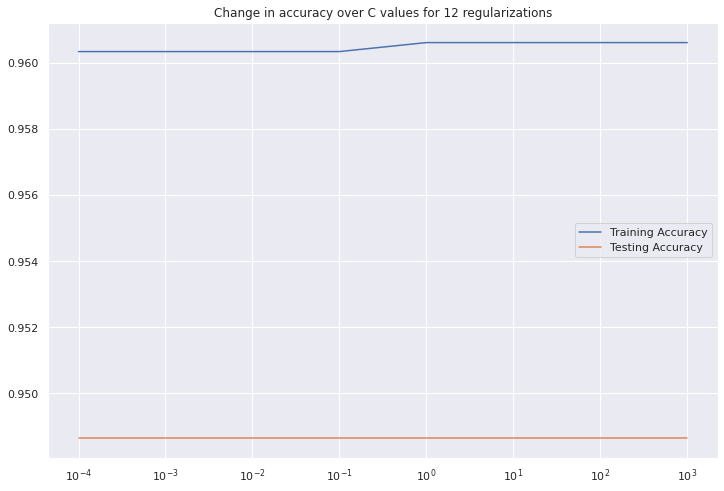

In [78]:
# optimizing our logistic regression model with L2 tuning to prevent overfitting
c_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores = []
test_scores = []

for c in c_values:
  log_reg2 = LogisticRegression(C=c, max_iter=1000, solver="liblinear", penalty="l2")
  log_reg_pipe2 = make_pipeline(transformer, log_reg2)
  log_reg_pipe2.fit(X_train, y_train)

  train_scores.append(log_reg_pipe2.score(X_train, y_train))
  test_scores.append(log_reg_pipe2.score(X_test, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label="Training Accuracy")
ax.plot(c_values, test_scores, label="Testing Accuracy")

ax.set(xticks=c_values, title="Change in accuracy over C values for 12 regularizations")
ax.legend()

ax.set_xscale("log")

{c:score for c, score in zip(c_values, test_scores)}

- No change in Score with L2 Tuning

### Calculating AUC and plotting ROC

In [79]:
print(f"Training Score: {roc_auc_score(y_train, logreg_pipe.predict_proba(X_train)[:,1])}")
print(f"Testing Score: {roc_auc_score(y_test, logreg_pipe.predict_proba(X_test)[:,1])}")

Training Score: 0.8469667318982388
Testing Score: 0.8623793159875633


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


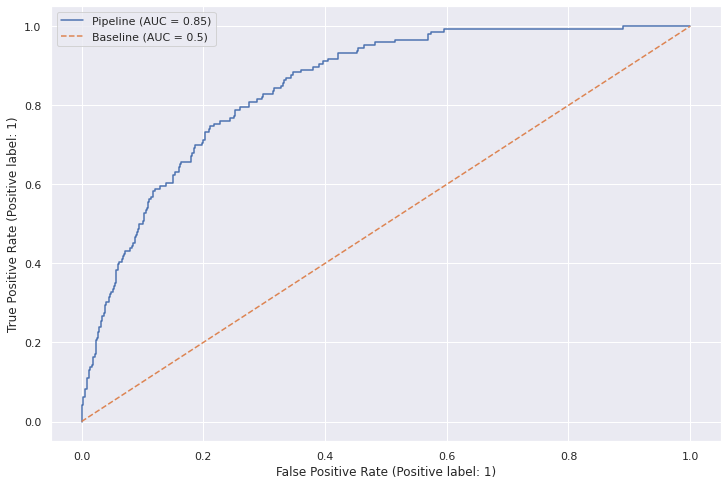

In [80]:
plot_roc_curve(logreg_pipe, X_train, y_train)
plt.plot([0, 1], [0, 1], ls="--", label="Baseline (AUC = 0.5)")
plt.legend()

- From the graph we can see that out AUC score is 0.85, so it does a fairly good job distinguishing between our classes.

### SMOTE Logistic Regression Model Scores

In [81]:
smote_logreg = LogisticRegression()

In [82]:
smote_scores(smote_logreg)

Smote Training Accuracy Score: 0.7886845827439887
Smote Testing Accuracy Score: 0.8062714776632303
------------------------------------------------------------------
Smote Training Recall Score: 0.8339462517680339
Smote Testing Recall Score: 0.8591065292096219
------------------------------------------------------------------
Smote Training Precision Score: 0.8339462517680339
Smote Testing Precision Score: 0.777000777000777


## Random Forest Model

In [83]:
# Instantiating our model
rf = RandomForestClassifier()

# creating pipeline for our model
rf_pipe = make_pipeline(transformer, rf)

# fitting our model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])),
                ('randomforestclassifier', RandomForestClassifier())])

### Random Forest Scores

In [84]:
print_scores(rf_pipe)

Accuracy Scores:

 RandomForestClassifier Training Score: 1.0
 RandomForestClassifier Testing Score: 0.9486552567237164
------------------------------------------------------------------

Recall Scores:

 RandomForestClassifier Training Score: 1.0
 RandomForestClassifier Testing Score: 0.015873015873015872
------------------------------------------------------------------

Precision Scores:

 RandomForestClassifier Training Score: 1.0
 RandomForestClassifier Testing Score: 0.5


- Our Random forest model had a horrible testing recall score meaning we have a lot of false negatives so in this case our model is predicting someone is not likely to have a stroke when they are likely to have a stroke. This could be because our model is highly imbalanced. The model also has a low precision score meaning we have a lot of false positives

### Hypertuning our model using GridSearchCV

In [85]:
rf_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline-1': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'columntransformer__pipeline-1__memory': None,
 'columntransformer__pipeline-1__standard

In [86]:
rf_params = {"randomforestclassifier__max_depth": [5, 10, 15],
             "randomforestclassifier__max_leaf_nodes": [10, 20, 30],
             "randomforestclassifier__n_estimators": [100, 200]}

In [87]:
rf_gs = GridSearchCV(rf_pipe, rf_params)

rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6750>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f87e39a6250>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [5, 10, 15],
                         'randomforestclassifier__max_leaf_nodes': [10, 20, 30],
                         'randomforestclassifier__n_estimators': [100, 200]})

In [88]:
# getting best params
rf_gs.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_leaf_nodes': 10,
 'randomforestclassifier__n_estimators': 100}

### Random Forest SMOTE Scores

In [89]:
# instantiating model
smote_rf = RandomForestClassifier(max_depth=15, max_leaf_nodes=30, n_estimators=100)

In [90]:
# smote Scores
smote_scores(smote_rf)

Smote Training Accuracy Score: 0.9072135785007072
Smote Testing Accuracy Score: 0.8767182130584192
------------------------------------------------------------------
Smote Training Recall Score: 0.9332390381895332
Smote Testing Recall Score: 0.8900343642611683
------------------------------------------------------------------
Smote Training Precision Score: 0.9332390381895332
Smote Testing Precision Score: 0.8669456066945607


- After some tuning we can see that our model with SMOTE performed far better than with our original data. Slightly overfit but overall way better recall and precision scores

# Chosing our final model

In [91]:
# repeating just for conclusion purposes
smote_scores(smote_rf)

Smote Training Accuracy Score: 0.9103253182461103
Smote Testing Accuracy Score: 0.8797250859106529
------------------------------------------------------------------
Smote Training Recall Score: 0.9346534653465347
Smote Testing Recall Score: 0.8900343642611683
------------------------------------------------------------------
Smote Training Precision Score: 0.9346534653465347
Smote Testing Precision Score: 0.8720538720538721


- The model that performed the best was our Random Forest Model with SMOTE. Our model was slightly overfit but outperformed all our other models in every aspect after a little bit of tuning. Our Random Forest Model would be our production model.